In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from abstract_ising import AbstractIsing
from ising_animator import IsingAnimator
import itertools as it

In this notebook, we will use simulated annealing on the Ising model, developed in Task_1, Task_2, and Task_3.
Here, the hamiltonian it applies to will now describe a graph partitioning problem [1](https://arxiv.org/pdf/1302.5843.pdf).
This is an interesting problem as an input to other graph problems - this algorithm will find two near-equivalient
and near-independent subsets (partitions) of the original graph.
As the two partitions are now smaller and almost independent (i.e. have a low number of connections) whatever graph
problem was intractable on the original large graph may now be small enough to solve.
For example, we can use this as an input to solving a graph problem on a quantum computer with fewer qubits than the
original graph.

We will begin by creating a random graph to work with.

array([0, 1, 2])

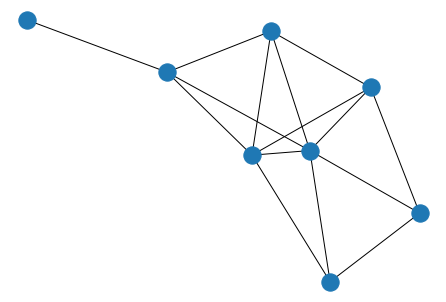

In [29]:
graph = nx.gnm_random_graph(8, 15)
nx.draw(graph)

The Hamiltonian to describe the graph partition problem is given by:
$$H  = H_A + H_B$$
where

$$H_A = A\left(\sum_{n=1}^{N} z_i \right)^2$$

which penalises for having the two sets (marked by the Ising spin values, $\pm1$) of unequal weight.
and

$$H_B = B \sum_{(uv \in E)} \frac{1 - z_uz_v}{2}$$

Which penalises for the number of connections across the subsets.
$A$ and $B$ are weights which we can determine, but for now we will weight each equally, $A = B = 0.5$.

Below we build the graph partition Ising model, with the energy defined as above.

In [30]:
class GraphPartitionIsingModel(AbstractIsing):
    def __init__(self, graph: nx.Graph, A: float, B: float):
        self.graph, self.A, self.B = graph, A, B
        self.num_spins = graph.number_of_nodes()
        self.spins = 2 * (np.random.rand(self.num_spins) < 0.5) - 1

    def edge_energy(self):
        energy = 0
        for edge in self.graph.edges:
            energy += (1 - self.spins[edge[0]] * self.spins[edge[1]]) / 2
        return energy

    def energy(self):
        energy = 0
        energy += self.A * np.sum(self.spins) ** 2
        energy += self.B * self.edge_energy()
        return energy

    def energy_diff(self, *coords):
        #naieve approach for now
        e0 = self.energy()
        self.spins[coords] *= -1
        e1 = self.energy()
        diff = e1 - e0
        self.spins[coords] *= -1
        return diff

    def rand_site(self):
        return [np.random.randint(self.num_spins)]

In [35]:
#  Here we will redefine some useful procedures written in Task_3
def exp_schedule(N: int = 500, T_i: float = 100, T_f = 0.005):
    t = np.arange(N+1)
    T = T_i * ((T_f/T_i) ** (t/N))
    return T

def simulated_anneal(ising, T):
    for t in T:
        energy = ising.mc_step(t)
    print('MC energy: {}'.format(energy))
    return energy

def loop_over_spins(ising: AbstractIsing):
    gs_energy = np.inf
    configs = it.product((-1, 1), repeat=ising.num_spins)
    best_config = None
    for spins in configs:
        ising.spins =  list(spins)
        current_energy = ising.energy()
        if current_energy < gs_energy:
            best_config = list(spins)
            gs_energy = current_energy
    print('Ground state energy: {}'.format(gs_energy))
    return gs_energy, best_config

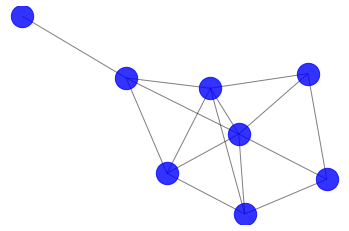

In [44]:
# and we need a function to display the final, partitioned graph
def draw_partition(graph_ising: GraphPartitionIsingModel, title:str = None):
    G = graph_ising.graph
    pos = nx.spring_layout(G)
    a_nodes = np.array(G.nodes)[np.where(graph_ising.spins == -1)]
    b_nodes = np.array(G.nodes)[np.where(graph_ising.spins == 1)]
    connecting_edges = []
    for edge in G.edges:
        diff_a = (edge[0] in a_nodes and edge[1] in b_nodes)
        diff_b = (edge[0] in b_nodes and edge[1] in a_nodes)
        if diff_a or diff_b:
            connecting_edges.append(edge)

    nx.draw_networkx_nodes(G,pos,
                       nodelist=a_nodes,
                       node_color='r',
                       node_size=500,
                       alpha=0.8)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=b_nodes,
                           node_color='b',
                           node_size=500,
                           alpha=0.8)

    # edges
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    nx.draw_networkx_edges(G,pos,
                           edgelist=connecting_edges,
                           width=2,alpha=0.5,edge_color='r')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

ising = GraphPartitionIsingModel(graph, 0.5, 0.5)
draw_partition(ising)

Now we have everything ready, let's run this problem on a few graph instances

In [67]:
def random_instance(n_nodes: int, n_edges: int = None, A: float = 0.5, B: float = 0.5, brute_force: bool = False,
                    quiet: bool = False):
    n_edges = int(n_nodes * 1.5) if n_edges is None else n_edges # allow for lazy definition of graph
    graph = nx.gnm_random_graph(n_nodes, n_edges)
    graph_ising = GraphPartitionIsingModel(graph, A, B)
    if not quiet:
        draw_partition(graph_ising, title='Starting graph:')
    schedule = exp_schedule()
    sim_en = simulated_anneal(graph_ising, schedule)
    if not quiet:
        draw_partition(graph_ising, title='Annealed graph, Energy: {}'.format(sim_en))
    if brute_force:
        en, spins = loop_over_spins(graph_ising)
        graph_ising.spins = np.array(spins)
        if not quiet:
            draw_partition(graph_ising, title='Brute Force graph, Energy: {}'.format(en))
        return 1 - (np.abs(sim_en - en) / en)

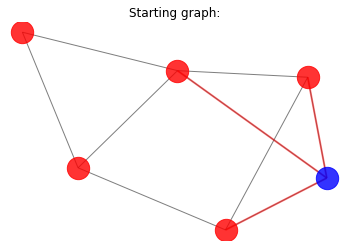

MC energy: 1.5
Ground state energy: 1.5
MC energy: 3.0
Ground state energy: 2.5
MC energy: 2.0
Ground state energy: 2.0
MC energy: 2.5
Ground state energy: 2.5
MC energy: 2.0
Ground state energy: 2.0
MC energy: 1.5
Ground state energy: 1.5
MC energy: 2.5
Ground state energy: 2.0
MC energy: 1.5
Ground state energy: 1.5
MC energy: 2.5
Ground state energy: 2.0
MC energy: 1.5
Ground state energy: 1.5


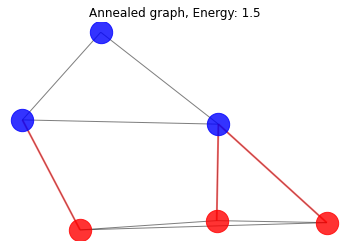

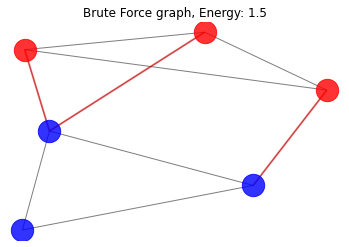

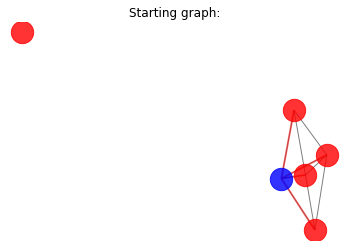

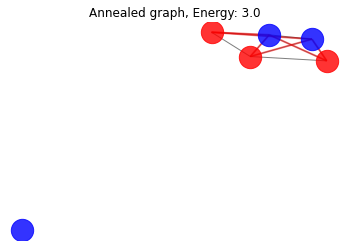

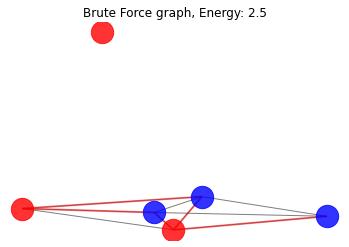

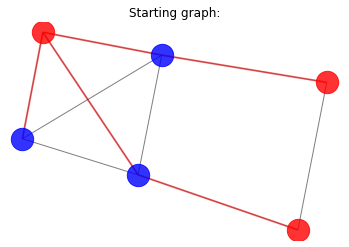

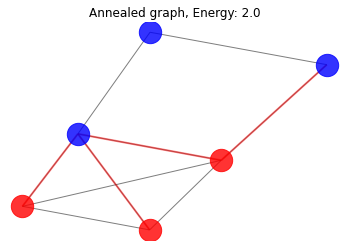

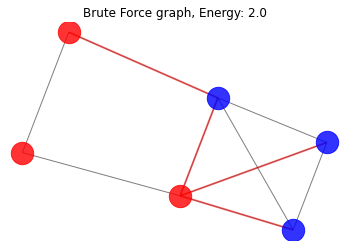

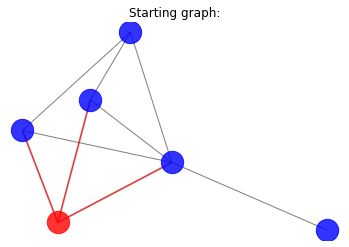

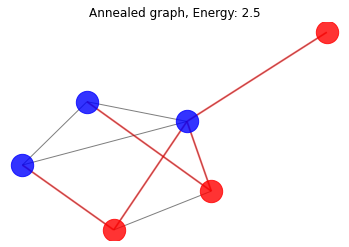

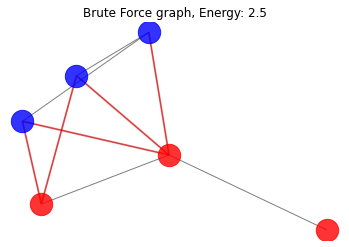

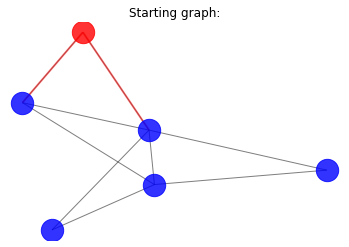

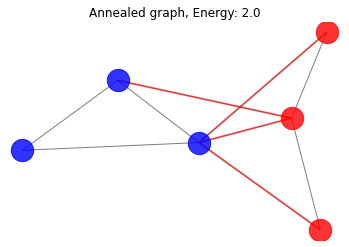

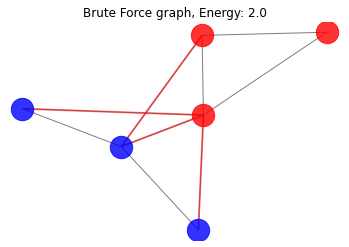

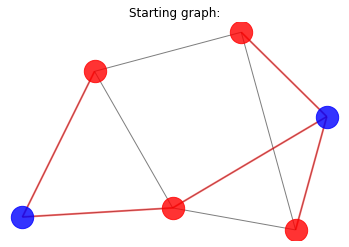

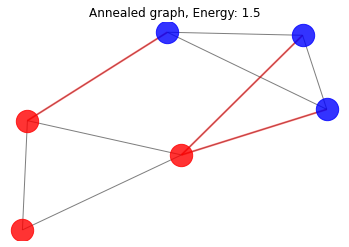

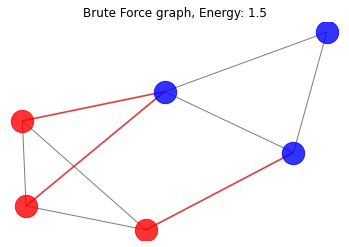

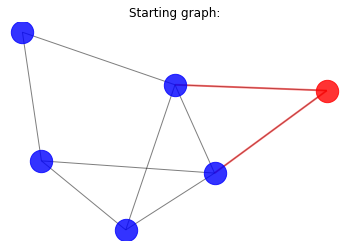

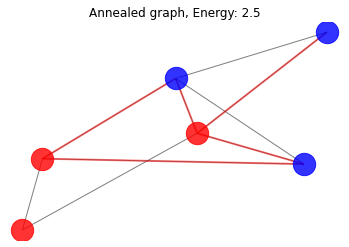

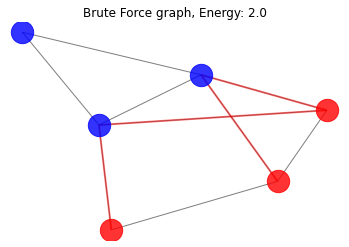

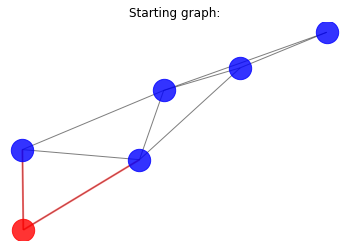

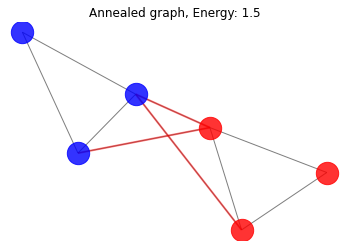

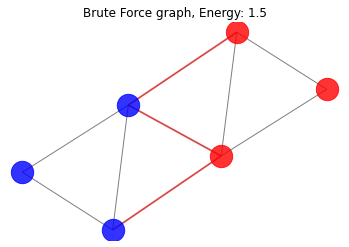

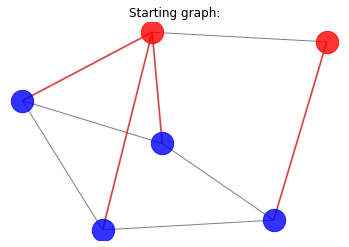

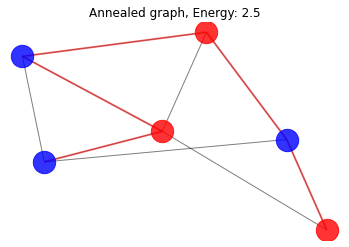

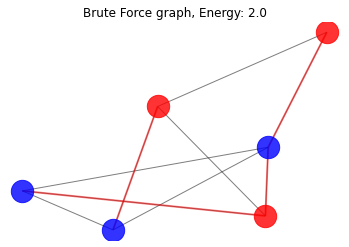

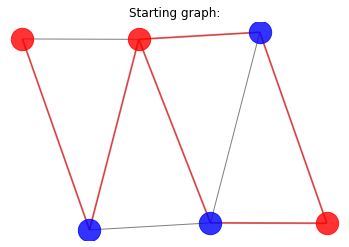

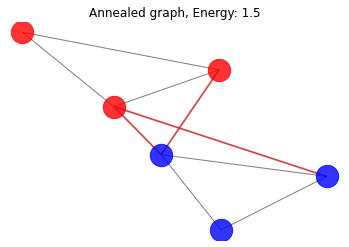

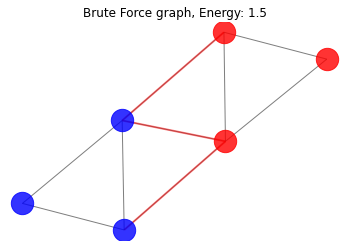

In [58]:
for _ in range(10):
    random_instance(6, brute_force=True)

In some instances the brute force graph has higher energy than the annealed graph.
We see that  this is due to the edges (the number of nodes in each set is always equal, implying that the A term is
dominating.

We can search over this hyperparameter for small instances to get a better idea of the right ratio of $A:B$.
Note however, that this is likely to change with the graph characteristics, e.g. ratio of nodes to edges, connectedness.

In [70]:
def hyperparameter_search(n_nodes: int, n_edges: int = None, n_repetitions: int = 10, n_searches: int = 10):
    step = 1 / n_searches
    ratio = np.arange(step, 1 + step, step)
    for r in ratio:
        acc = 0
        A = r
        B = 1 - r
        for n in range(n_repetitions):
            acc += random_instance(n_nodes, n_edges, A, B, brute_force=True, quiet=True)
        acc /= n_repetitions
        print('A = {}, B = {}, Accuracy = {}\n'.format(A, B, acc))

In [69]:
# Lets run the hyperparameter search on a larger set of random graphs to gain some useful info.
hyperparameter_search(12)

MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
MC energy: 0.0
Ground state energy: 0.0
A = 0.0, B = 1.0, Accuracy = nan

MC energy: 4.5
Ground state energy: 4.0
MC energy: 4.0
Ground state energy: 4.0
MC energy: 4.5
Ground state energy: 4.5
MC energy: 4.0
Ground state energy: 3.1
MC energy: 4.0
Ground state energy: 4.0
MC energy: 3.4000000000000004
Ground state energy: 3.4000000000000004
MC energy: 4.5
Ground state energy: 4.5
MC energy: 3.1
Ground state energy: 3.1
MC energy: 4.0
Ground state energy: 4.0
MC energy: 3.6
Ground state energy: 3.6
A = 0.1, B = 0.9, Accuracy = 0.958467741935484

MC energy: 4.0
Ground state energy: 4.0
MC energy: 4.0
Ground state energy: 3.2
MC energ

/home/andrew/Documents/PhD/CDLQuantum/CDLenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In this instance, it seems that the accuracy is best when $A = 0.2, B = 0.8$, which is far from the naieve
implementation of $A = B = 0.5$, showing the usefulness of running a hyperparameter search.

 However, it is not obvious
that these parameters will hold for other graph instances. It may be useful to runa  hyperparameter search on smaller
graphs with the same charachteristics before annealing on the whole model.


